In [1]:
import pandas as pd
import ast
import re
import json
from sklearn import linear_model
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy import sparse

c:\users\samir\appdata\local\programs\python\python37\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
reviews = []
with open('snapchat-100pages-reviews.txt', 'r', encoding='utf-8') as f:
    reviews = f.read()

reviews = re.sub('\]', '', reviews)
reviews = re.sub('\[', '', reviews)
reviews = re.sub('\n', '', reviews)
reviews = re.sub("'", '"', reviews)
reviews = re.sub('    ', ' ', reviews)
reviews = re.sub(' {', '{', reviews)
reviews = re.sub(' }', '}', reviews)
reviews = re.sub('{ ', '{', reviews)
reviews = re.sub('} ', '}', reviews)
reviews = re.sub('}  {', '}, {', reviews)
reviews = re.sub('}{', '}, {', reviews)
reviews = re.sub('id:', '"id":', reviews)
reviews = re.sub('userName:', '"userName":', reviews)
reviews = re.sub('userImage:', '"userImage":', reviews)
reviews = re.sub('date:', '"date":', reviews)
reviews = re.sub('url:', '"url":', reviews)
reviews = re.sub('score:', '"score":', reviews)
reviews = re.sub('title:', '"title":', reviews)
reviews = re.sub('text:', '"text":', reviews)
reviews = re.sub('replyDate:', '"replyDate":', reviews)
reviews = re.sub('replyText:', '"replyText":', reviews)
reviews = re.sub(': undefined', ': "undefined"', reviews)

In [3]:
review_strings = [r+'}' for r in reviews.split('},')]
review_strings[-1] = review_strings[-1][:-1]

In [4]:
review_list = []
for r in review_strings:
    try:
        review_list.append(json.loads(r))
    except:
        pass

In [5]:
review_list[0]

{'id': 'gp:AOqpTOFEwBqdIY9EWRFIge7rrQTO2Hqn046SnyvrMz11nfMzZy95jDLXqzEdlZ6s4hAR6n1LKhaXp5BUl4q_FA',
 'userName': '',
 'userImage': 'https://lh6.googleusercontent.com/-GVea0Srlla4/AAAAAAAAAAI/AAAAAAAAAAA/QzrUwIMDqEQ/w96-h96-p/photo.jpg',
 'date': 'September 27, 2018',
 'url': 'https://play.google.com/store/apps/details?id=com.snapchat.android&reviewId=Z3A6QU9xcFRPRkV3QnFkSVk5RVdSRklnZTdyclFUTzJIcW4wNDZTbnl2ck16MTFuZk16Wnk5NWpETFhxekVkbFo2czRoQVI2bjFMS2hhWHA1QlVsNHFfRkE',
 'score': 5,
 'title': '',
 'text': '100% service',
 'replyDate': 'undefined',
 'replyText': 'undefined'}

In [6]:
review_text = [r['text'] for r in review_list]
review_dates = [r['date'] for r in review_list]
review_scores = [r['score'] for r in review_list]

In [11]:
sid = SentimentIntensityAnalyzer()

pscores = []
lens = []
for sentence in review_text:
    pscores.append(abs(sid.polarity_scores(sentence)['compound']))
    lens.append(np.log(len(sentence.split('.'))))
    
#pscores = np.reshape(pscores, [-1,1])

In [9]:
np.unique(review_dates)

array(['September 24, 2018', 'September 25, 2018', 'September 26, 2018',
       'September 27, 2018'], dtype='<U18')

In [12]:
train_text, test_text, train_scores, test_scores, train_pscores, test_pscores, train_lens, test_lens = train_test_split(review_text, review_scores, pscores, lens, random_state=2)

cv = CountVectorizer(min_df=2, ngram_range=(0,2))
cv_train_sentences = cv.fit_transform(train_text)
cv_test_sentences = cv.transform(test_text)

train_pscore_sparse = sparse.csr_matrix(train_pscores)
train_pscore_int = sparse.csc_matrix.multiply(np.transpose(train_pscore_sparse), cv_train_sentences)
#stacked_train_sentences = sparse.hstack([cv_train_sentences, np.transpose(train_pscore_sparse), train_pscore_int])
stacked_train_sentences = sparse.hstack([cv_train_sentences, np.transpose(train_pscore_sparse), np.transpose(sparse.csr_matrix(train_lens))])


test_pscore_sparse = sparse.csr_matrix(test_pscores)
test_pscore_int = sparse.csc_matrix.multiply(np.transpose(test_pscore_sparse), cv_test_sentences)
#stacked_test_sentences = sparse.hstack([cv_test_sentences, np.transpose(test_pscore_sparse), test_pscore_int])
stacked_test_sentences = sparse.hstack([cv_test_sentences, np.transpose(test_pscore_sparse), np.transpose(sparse.csr_matrix(test_lens))])

In [27]:
np.transpose(train_lens).shape

(2979,)

In [504]:
np.transpose(train_pscores).shape

(2979,)

In [502]:
np.multiply(train_pscores, train_lens).shape

(2979,)

In [538]:
train_df = np.transpose(np.stack((train_pscores, train_lens, np.transpose(np.multiply(train_pscores, train_lens))), axis=0))
test_df = np.transpose(np.stack((test_pscores, test_lens, np.transpose(np.multiply(test_pscores, test_lens))), axis=0))

In [521]:
lm.coef_

array([ 1.13807138, -0.52746403,  0.08262148])

In [13]:
lm = linear_model.Ridge()
lm.fit(cv_train_sentences, train_scores)
preds = lm.predict(cv_test_sentences)
print(mean_squared_error(preds, test_scores))

1.154458263579385


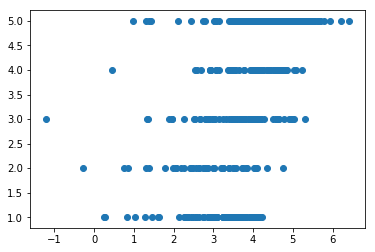

In [14]:
plt.scatter(preds, test_scores)
plt.show()

In [25]:
test_text[974]

'I had my old account for almost a year now. But I just bought a new phone and it didn"t let me log into my snap so I made a new one and I logged out today to give my friend to log in. And now I can"t log back on and my email is the same. I"m recieving email from you guys that someone is trying to log in, but that"s me and when I say to verify through email it"s says email not recognized. Fix it please asap.'

In [22]:
cv_featurenames = cv.get_feature_names()


weightIndeces_positive = np.argsort(lm.coef_)[-20:]
weightIndeces_negative = np.argsort(lm.coef_)[:20]

In [23]:
for index in weightIndeces_positive: 
    print(cv_featurenames[index])

also
streaks
love this
lovely
love it
like it
text
ve
friends
or
that
like
good
nice
great
best
amazing
cool
awesome
love


In [24]:
for index in weightIndeces_negative: 
    print(cv_featurenames[index])

bad
worst
not
sucks
keeps
camera
slow
open
update
hate
cant
crashes
why
old
fix
android
work
on
its not
suck
